# Analyse Pratique de l'Éligibilité au Crédit

# Introduction au Projet

Dans ce projet, nous allons réaliser une analyse économétrique pour comprendre les facteurs influençant l'approbation de demandes de cartes de crédit. Grâce à un petit jeu de données fourni par Kaggle, nous explorerons les principales caractéristiques démographiques et financières des demandeurs de crédit afin de déterminer les variables qui influencent le plus la probabilité d’approbation. Cette étude pratique vise à fournir des insights utiles pour les institutions financières qui cherchent à évaluer la solvabilité et les risques associés aux nouveaux clients.

## Objectifs du Projet
1. **Comprendre les déterminants de l'approbation des cartes de crédit** : Analyser les variables influençant la décision d'octroi de crédit (variable cible : *card*).
2. **Modélisation prédictive** : Construire un modèle prédictif qui utilise les caractéristiques du demandeur pour estimer la probabilité d’approbation.
3. **Visualisation et interprétation des résultats** : Identifier les tendances et les corrélations principales pour apporter des insights exploitables.

## Description des Variables Clés
Le jeu de données comporte des variables qui décrivent à la fois les informations démographiques et financières des demandeurs :

- **card** : Variable binaire indiquant si la demande de carte de crédit a été approuvée (1) ou refusée (0). C'est notre variable cible pour l'analyse.
- **reports** : Nombre de rapports négatifs majeurs associés au demandeur, ce qui peut être un indicateur de risque.
- **age** : Âge du demandeur en années et fractions d’année.
- **income** : Revenu annuel du demandeur (en unités de 10,000 $), une mesure de la capacité de remboursement.
- **share** : Ratio de la dépense mensuelle par carte de crédit par rapport au revenu annuel, indiquant l'utilisation du crédit par rapport au revenu.
- **expenditure** : Dépense moyenne mensuelle par carte de crédit.
- **owner** : Variable binaire indiquant si le demandeur est propriétaire (1) ou locataire (0).
- **selfempl** : Indique si le demandeur est travailleur indépendant (1) ou non (0).
- **dependents** : Nombre de personnes à charge (1 plus le nombre de personnes à charge).
- **months** : Nombre de mois de résidence à l'adresse actuelle, souvent utilisé comme un indicateur de stabilité.
- **majorcards** : Nombre de cartes de crédit majeures détenues, une mesure de l'accès actuel au crédit.
- **active** : Nombre de comptes de crédit actifs, une indication du niveau d’activité de crédit actuel.

## Méthodologie
Nous utiliserons **Google Colab** pour l'analyse et le traitement des données, ainsi que pour la modélisation. Le processus se déroulera en plusieurs étapes :
1. **Exploration des données** : Nettoyage et analyse descriptive pour comprendre la répartition et les caractéristiques des variables.
2. **Préparation des données** : Transformation des données et traitement des valeurs manquantes ou aberrantes, si nécessaire.
3. **Modélisation** : Utilisation de techniques de régression logistique ou d'autres algorithmes supervisés pour prédire l'approbation de crédit.
4. **Interprétation des résultats** : Évaluation de l'importance des variables pour comprendre les facteurs principaux influençant l'éligibilité au crédit.

## Résultats Attendus
À travers cette analyse, nous espérons :
- Identifier les caractéristiques des demandeurs qui influencent le plus les décisions d'approbation de cartes de crédit.
- Fournir un modèle prédictif permettant aux institutions de mieux évaluer les risques et d’optimiser le processus de sélection des candidats.
- Aider les demandeurs à mieux comprendre les critères d’éligibilité pour augmenter leurs chances d’approbation.

Ce projet constitue une application pratique de l’IA et des méthodes statistiques dans le domaine de la finance et de la gestion des risques, en permettant de mieux comprendre et quantifier les facteurs de décision pour l’octroi de crédit.


## Importation des bibliotheques

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import missingno as msno
from sklearn.model_selection import train_test_split

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator
from sklearn.utils import check_X_y

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [30]:
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

In [69]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [70]:

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

### Fonctions utilisées

In [25]:
def feature_selection(X, y):
    """
    Perform feature selection using various methods.

    Parameters:
        X (DataFrame): Independent variables.
        y (Series): Categorical target variable.

    Returns:
        feature_selection_df (DataFrame): DataFrame indicating feature selection results.
    """
    y_numerical = y['card']
    cor_list = []
    # Pearson Correlation
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y_numerical)[0, 1]
        cor_list.append(cor)
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:, np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in X.columns]

    # Chi-2
    k= len(X.columns)
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=k)
    chi_selector.fit(X_norm, y_numerical)
    chi_support = chi_selector.get_support()

    # Wrapper (RFE & RFEcv)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=10, verbose=5)
    rfe_selector.fit(X_norm, y_numerical)
    rfe_support = rfe_selector.get_support()

    # Embedded (L1)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"))
    embeded_lr_selector.fit(X_norm, y_numerical)
    embeded_lr_support = embeded_lr_selector.get_support()

    # Random Forest
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=17))
    embeded_rf_selector.fit(X, y_numerical)
    embeded_rf_support = embeded_rf_selector.get_support()

    # LightGBM
    lgbc = LGBMClassifier(n_estimators=18, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                          reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    embeded_lgb_selector = SelectFromModel(lgbc)
    embeded_lgb_selector.fit(X, y_numerical)
    embeded_lgb_support = embeded_lgb_selector.get_support()

    # Summary
    feature_selection_df = pd.DataFrame({'Feature': X.columns,
                                         'Pearson': cor_support,
                                         'Chi-2': chi_support,
                                         'RFE': rfe_support,
                                         'Logistics': embeded_lr_support,
                                         'Random Forest': embeded_rf_support,
                                         'LightGBM': embeded_lgb_support})

    feature_selection_df['Total'] = np.sum(feature_selection_df.iloc[:, 1:], axis=1)
    feature_selection_df = feature_selection_df.sort_values(['Total', 'Feature'], ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df) + 1)

    return feature_selection_df



def select_features_by_vote(feature_selection_df, vote):
    """
    Select features based on a vote threshold.

    Parameters:
        feature_selection_df (DataFrame): DataFrame indicating feature selection results.
        vote (int): The vote threshold.

    Returns:
        selected_features (list): List of selected features.
    """
    selected_features = feature_selection_df.loc[feature_selection_df['Total'] >= vote, 'Feature'].tolist()
    #selected_features.append('target')
    return selected_features

In [62]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

## Importation des données

In [ ]:
# 1er cas :Clonage du dépôt GitHub
!git clone https://github.com/bilelammouri/workshop-Mathematique-de-l-IA.git

In [3]:
# 2eme Cas : télécharger depuis le bureau
from google.colab import files
uploaded = files.upload()

Saving AER_credit_card_data.csv to AER_credit_card_data.csv


In [4]:
# Lire les données
file_path = 'AER_credit_card_data.csv'
df = pd.read_csv(file_path, sep=',')

In [5]:
df.head(2)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13


## Data understand (EDA)

In [6]:
# Information sur les données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


In [7]:
# Grouper les données
cat_feats = [col for col in df.columns if df[col].dtypes == "object"]
num_feats =  [col for col in df.columns if df[col].dtypes != "object"]

print("no of cat feats: ", len(cat_feats))
print("no of num feats: ", len(num_feats))

no of cat feats:  3
no of num feats:  9


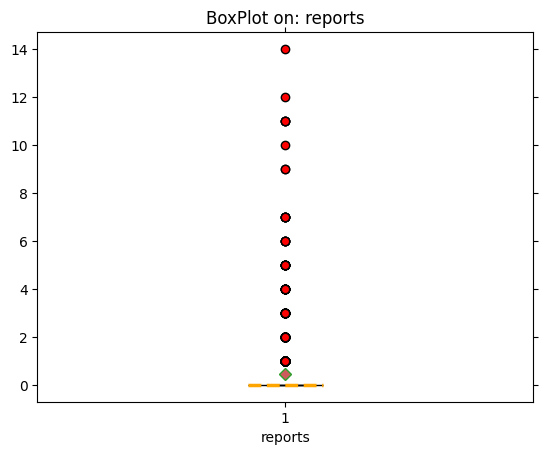

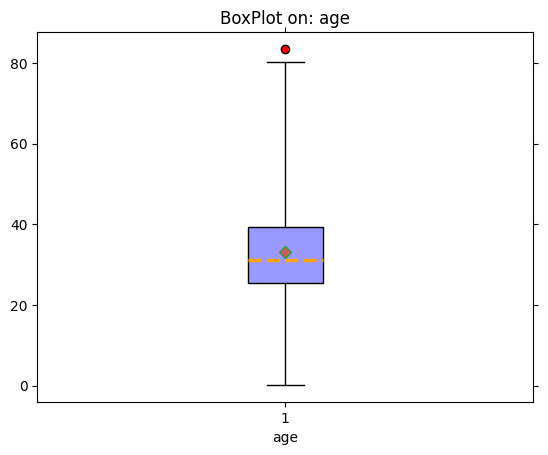

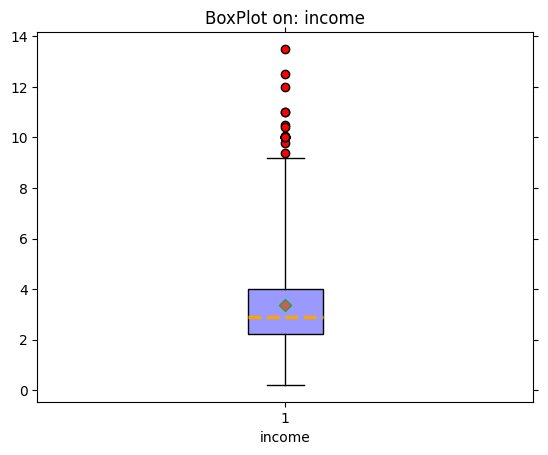

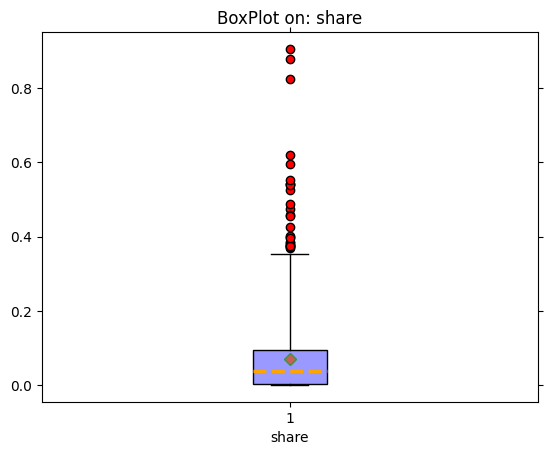

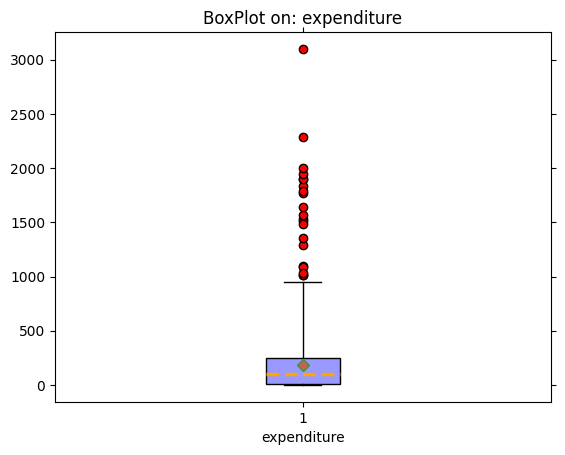

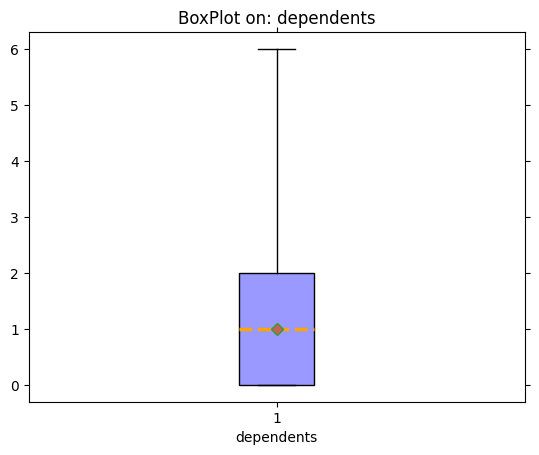

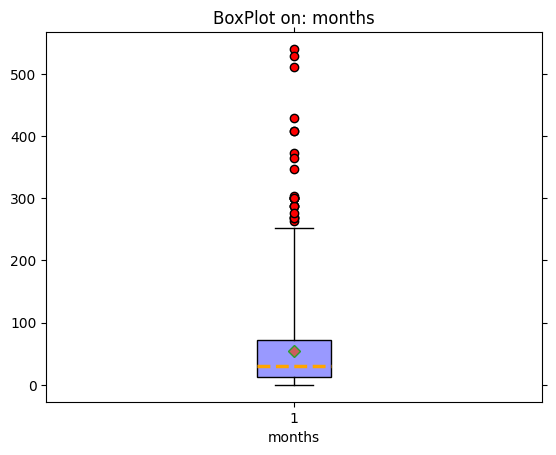

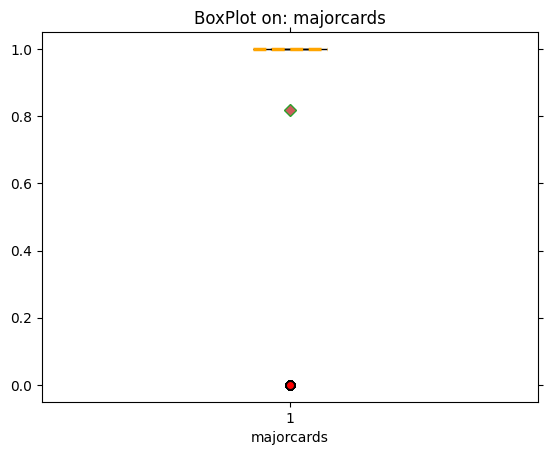

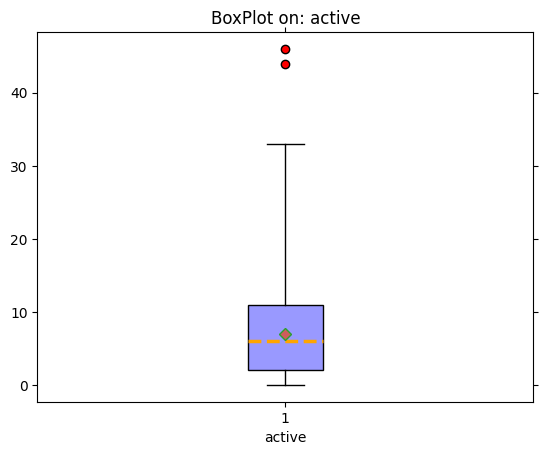

In [8]:
# Boxplot for quantitative data

for col in num_feats:
        plt.boxplot(x=df[col],
                    whis=3,
                    patch_artist=True,
                    showmeans=True,
                    boxprops={'color': 'black', 'facecolor': '#9999ff'},
                    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'color': 'black'},
                    meanprops={'marker': 'D', 'markerfacecolor': 'indianred'},
                    medianprops={'linestyle': '--', 'linewidth': 2.5, 'color': 'orange'})
        plt.tick_params(top='off', right='off')
        plt.xlabel("" + col)
        plt.title("BoxPlot on: " + col)
        plt.show()

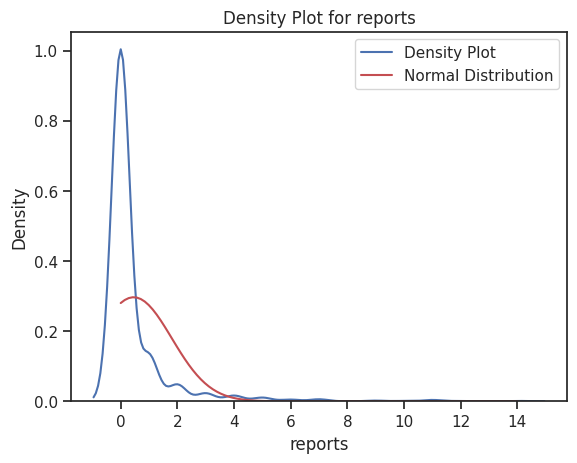

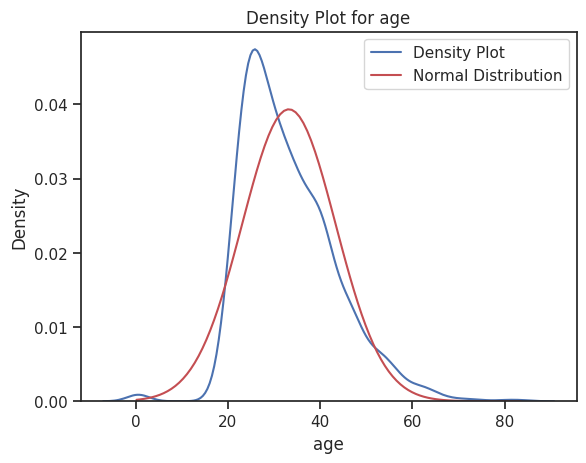

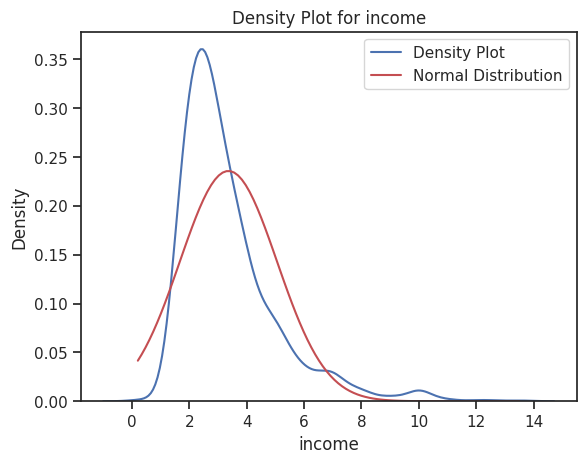

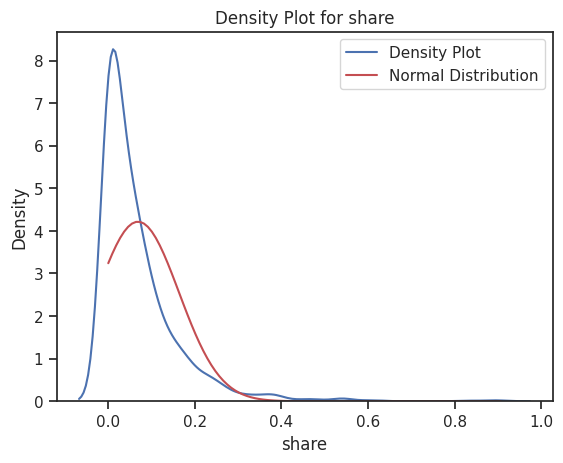

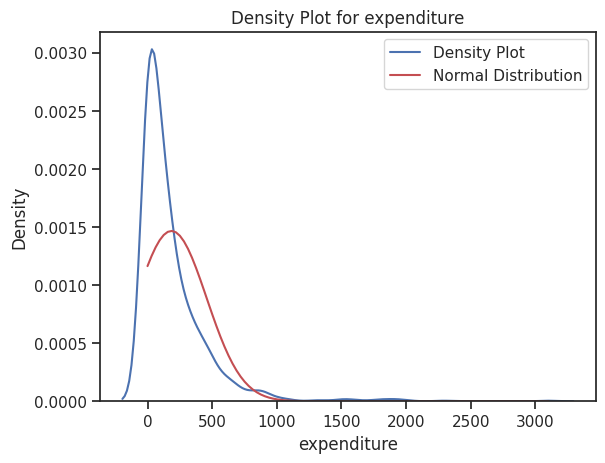

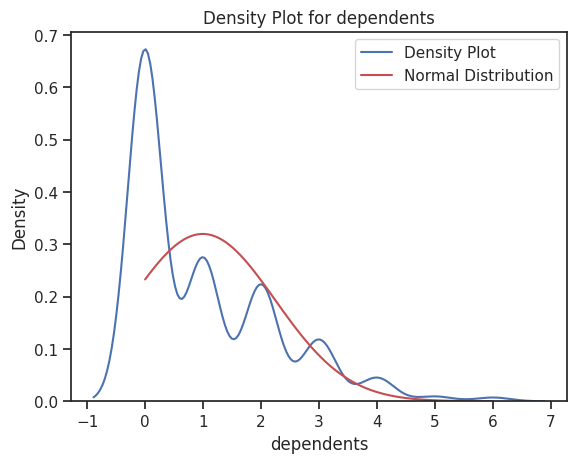

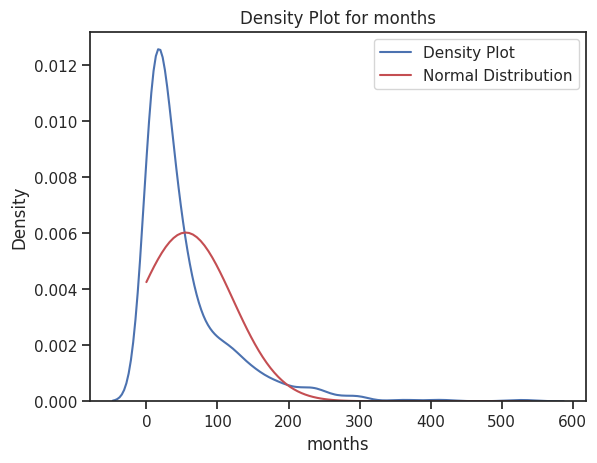

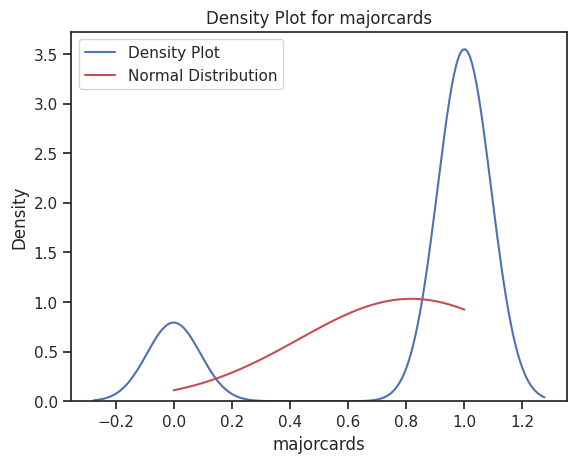

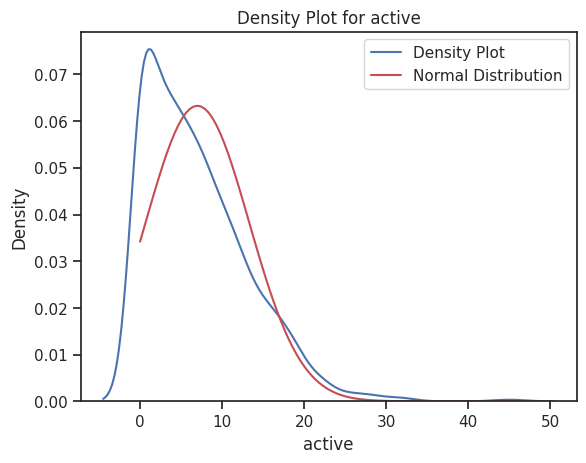

In [9]:
# Density for quantitative data vs. normal distribution
sns.set(style="ticks")

for column in df[num_feats].columns:
    # Get cleaned data of the column
    cleaned_data = df[column]

    # Exclude non-finite values from the calculation
    cleaned_data = cleaned_data[np.isfinite(cleaned_data)]

    # Calculate parameters of the normal distribution (mean and standard deviation)
    mean, std = norm.fit(cleaned_data)

    # Generate a sample of values for the probability density function of the normal distribution
    x = np.linspace(cleaned_data.min(), cleaned_data.max(), 100)
    y = norm.pdf(x, mean, std)

    # Plot the density plot with the normal distribution
    plt.figure()
    sns.kdeplot(data=cleaned_data, label="Density Plot")
    plt.plot(x, y, 'r-', label="Normal Distribution")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.title('Density Plot for ' + column)
    plt.show()


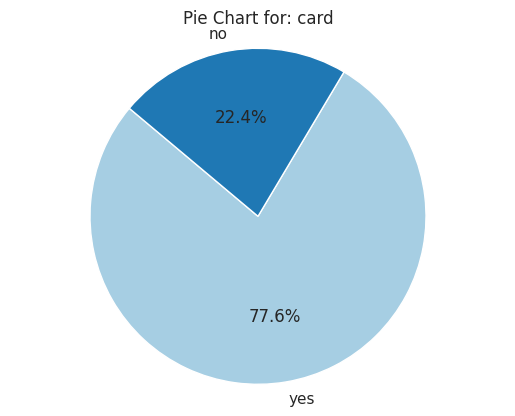

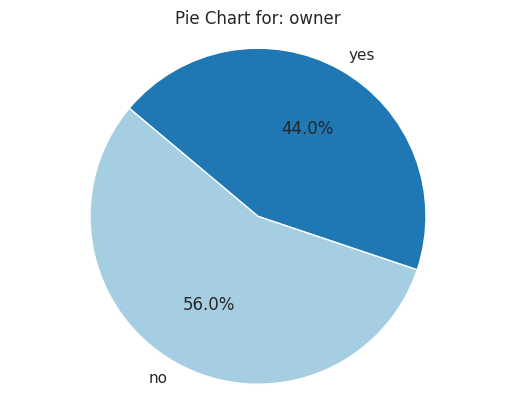

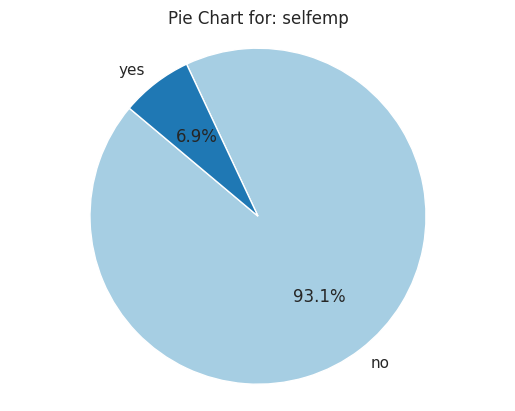

In [10]:
# Pie char for qualitative variables

for col in cat_feats:
        value_counts = df[col].value_counts()
        labels = value_counts.index
        sizes = value_counts.values

        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.title("Pie Chart for: " + col)
        plt.show()

## Data preprocessing

### Valeurs manquantes

In [15]:
df.isnull().sum().sort_values(ascending=False).head(10)

,0
card,0
reports,0
age,0
income,0
share,0
expenditure,0
owner,0
selfemp,0
dependents,0
months,0


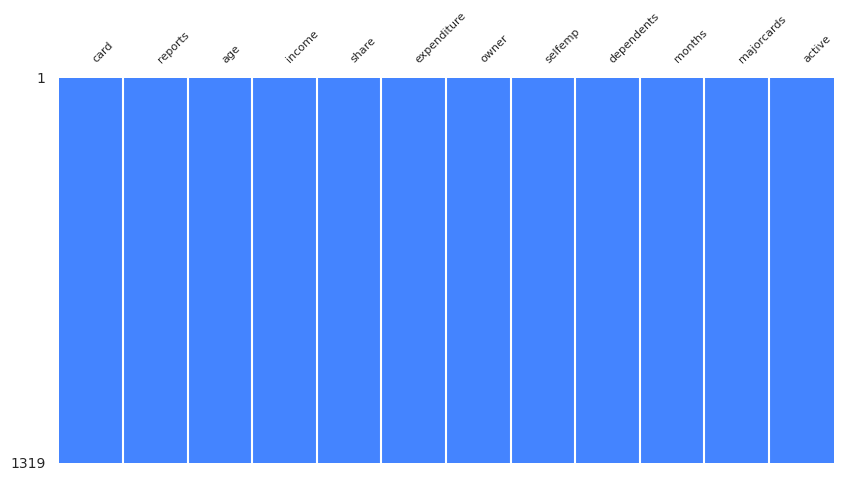

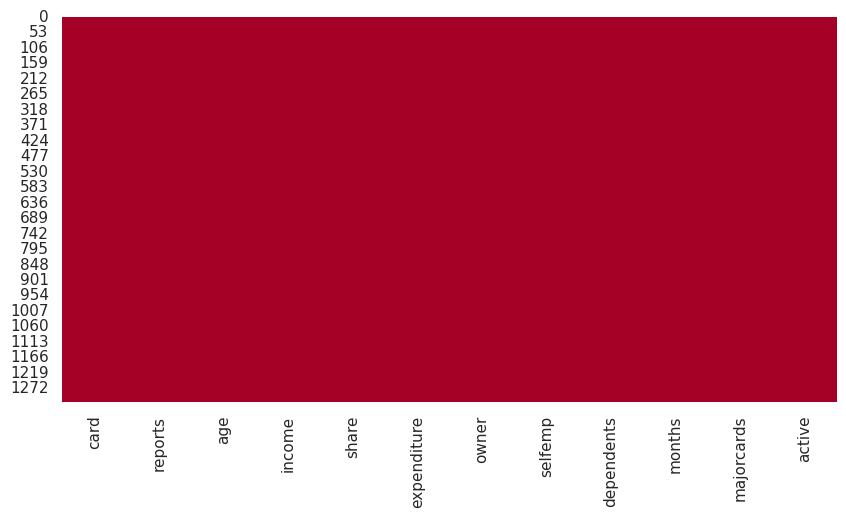

In [11]:
# Visualize missing values
msno.matrix(df, sparkline=False, figsize=(10, 5), fontsize=8, color=(0.27, 0.52, 1.0))
plt.show()

sns.set(style="white")
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cmap="RdYlGn", cbar=False)
plt.show()

### Data transformation

In [48]:
df.head(2)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,1,0,37.66667,4.52,0.033270,124.983300,1,0,3,54,1,12
1,1,0,33.25000,2.42,0.005217,9.854167,0,0,3,34,1,13


In [16]:
# Remplacer les valeurs des variables qualitatives
df['owner'] = df['owner'].map({'yes':1, 'no':0})
df['selfemp'] = df['selfemp'].map({'yes':1, 'no':0})
df['card'] = df['card'].map({'yes':1, 'no':0})

### Spliting Data

In [19]:
# Diver les données en train et test
train_AER, test_AER = train_test_split(df, train_size=0.7, random_state=42)

In [20]:
print(train_AER.shape)
print(test_AER.shape)

(923, 12)
(396, 12)


### Feature selection

In [28]:
# train
X_AER = train_AER.drop('card', axis=1)
y_AER = train_AER[['card']]
# test
X_AER_t = test_AER.drop('card', axis=1)
y_AER_t = test_AER[['card']]

In [29]:
X_AER.shape, X_AER_t.shape, y_AER.shape, y_AER_t.shape

((923, 11), (396, 11), (923, 1), (396, 1))

In [27]:
feature_selection_AER = feature_selection(X_AER, y_AER)
selected_features_AER = select_features_by_vote(feature_selection_AER, vote=4)
feature_selection_AER

[LightGBM] [Info] Number of positive: 717, number of negative: 206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1150
[LightGBM] [Info] Number of data points in the train set: 923, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.776815 -> initscore=1.247200
[LightGBM] [Info] Start training from score 1.247200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=20 > n_features=11. There will be no feature selection and all features will be kept.
  warnings.warn(


,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,share,True,True,True,True,True,True,6
2,expenditure,True,True,True,True,True,False,5
3,reports,True,True,True,True,False,False,4
4,owner,True,True,True,False,False,True,4
5,dependents,True,True,True,False,False,True,4
6,age,True,True,True,False,False,True,4
7,selfemp,True,True,True,False,False,False,3
8,months,True,True,True,False,False,False,3
9,majorcards,True,True,True,False,False,False,3
10,income,True,True,True,False,False,False,3


## Modeling

In [34]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr_fit = lr.fit(X_AER, y_AER)
roc_auc = roc_auc_score(y_AER_t, lr.predict_proba(X_AER_t)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_AER_t, lr.predict(X_AER_t)))

AUC : 0.9876
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        90
           1       1.00      0.91      0.95       306

    accuracy                           0.93       396
   macro avg       0.88      0.95      0.91       396
weighted avg       0.94      0.93      0.93       396

CPU times: user 44.9 ms, sys: 25.4 ms, total: 70.3 ms
Wall time: 40.3 ms


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


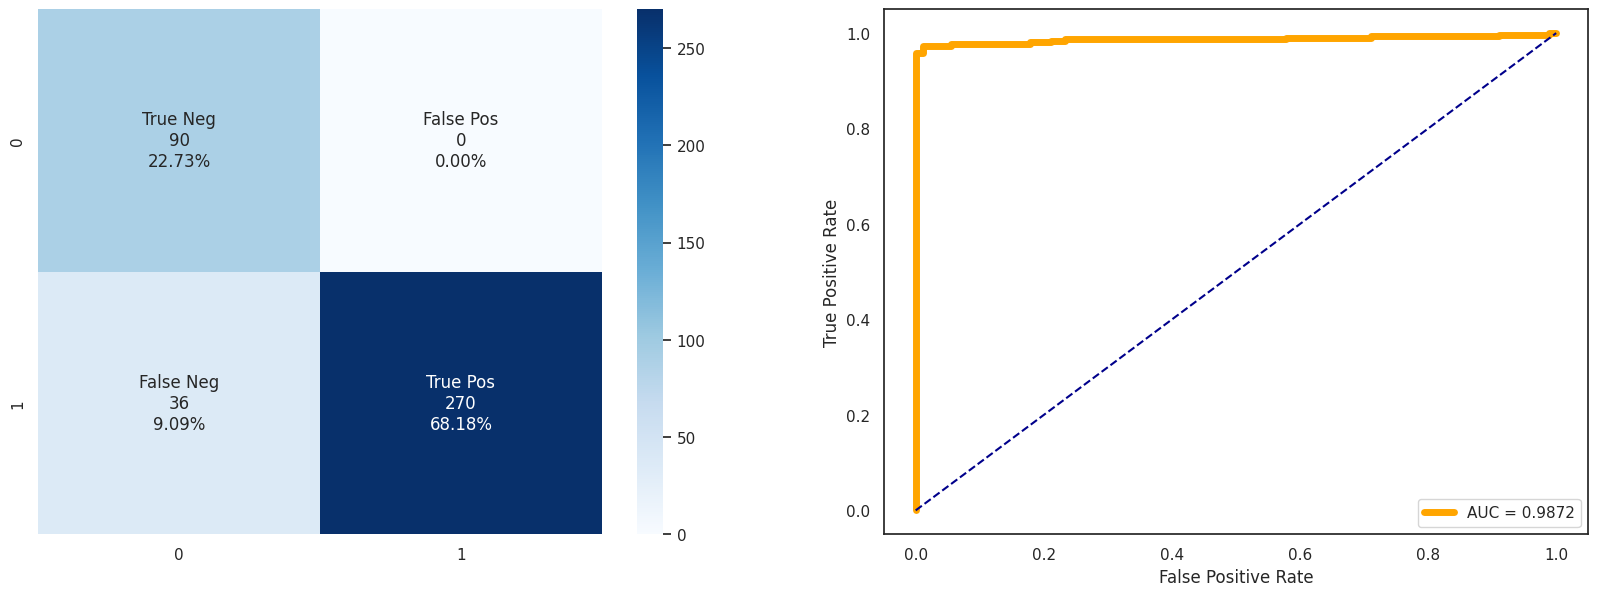

In [63]:
cf_matrix_roc_auc(lr, y_AER_t, lr.predict(X_AER_t), lr.predict_proba(X_AER_t)[:,1])

### Oversampling Data Using SMOTE

In [56]:
print("Label 1, Before using SMOTE: {}".format((y_AER.card == 1).sum()))
print("Label 0, Before using SMOTE: {}".format((y_AER.card == 0).sum()))

Label 1, Before using SMOTE: 717
Label 0, Before using SMOTE: 206


In [58]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res  = sm.fit_resample(X_AER, y_AER)

In [59]:
print("Label 1, After using SMOTE: {}".format((y_train_res.card == 1).sum()))
print("Label 0, After using SMOTE: {}".format((y_train_res.card == 0).sum()))

Label 1, After using SMOTE: 717
Label 0, After using SMOTE: 717


In [61]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_AER_t, lr.predict_proba(X_AER_t)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_AER_t, lr.predict(X_AER_t)))

AUC : 0.9872
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        90
           1       1.00      0.88      0.94       306

    accuracy                           0.91       396
   macro avg       0.86      0.94      0.89       396
weighted avg       0.94      0.91      0.91       396

CPU times: user 46.7 ms, sys: 29.2 ms, total: 76 ms
Wall time: 41.3 ms


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


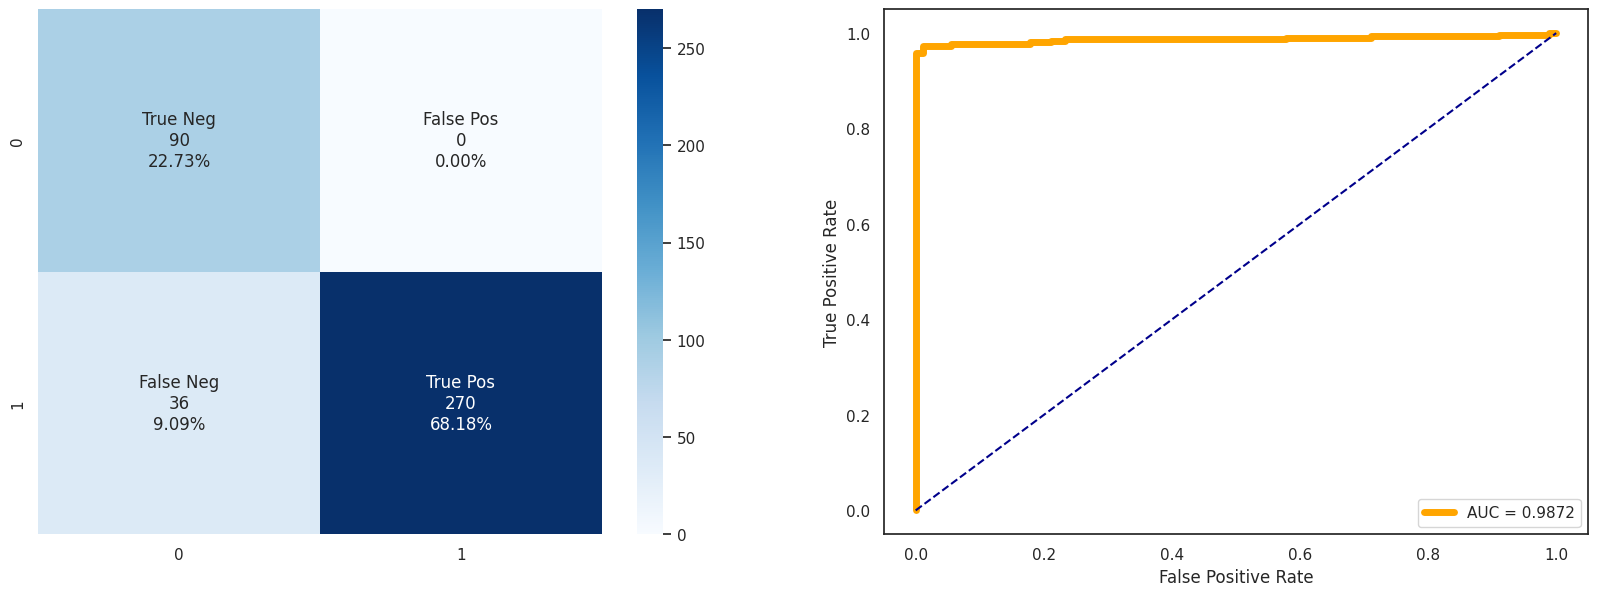

In [65]:
cf_matrix_roc_auc(lr, y_AER_t, lr.predict(X_AER_t), lr.predict_proba(X_AER_t)[:,1])

### Gradient Boosting

In [79]:
#Predictive Models
models = [
          CatBoostClassifier(),
          LGBMClassifier(),
          XGBClassifier()]

In [80]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }

    return output

In [81]:
name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    results = train_models(model, X_AER, X_AER_t, y_AER, y_AER_t)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

Learning rate set to 0.009956
0:	learn: 0.6718932	total: 48.6ms	remaining: 48.6s
1:	learn: 0.6513182	total: 50.8ms	remaining: 25.3s
2:	learn: 0.6308190	total: 52.9ms	remaining: 17.6s
3:	learn: 0.6083556	total: 54.9ms	remaining: 13.7s
4:	learn: 0.5868641	total: 57ms	remaining: 11.3s
5:	learn: 0.5661211	total: 59ms	remaining: 9.77s
6:	learn: 0.5478060	total: 60.9ms	remaining: 8.64s
7:	learn: 0.5294857	total: 62.9ms	remaining: 7.8s
8:	learn: 0.5093835	total: 64.4ms	remaining: 7.09s
9:	learn: 0.4926692	total: 66.4ms	remaining: 6.57s
10:	learn: 0.4747333	total: 68.3ms	remaining: 6.14s
11:	learn: 0.4604747	total: 70.4ms	remaining: 5.79s
12:	learn: 0.4444531	total: 72.1ms	remaining: 5.47s
13:	learn: 0.4302063	total: 74.2ms	remaining: 5.22s
14:	learn: 0.4153797	total: 76.2ms	remaining: 5s
15:	learn: 0.4021871	total: 78.1ms	remaining: 4.8s
16:	learn: 0.3902332	total: 80.2ms	remaining: 4.63s
17:	learn: 0.3767949	total: 82.1ms	remaining: 4.48s
18:	learn: 0.3647709	total: 84.1ms	remaining: 4.34s
1

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [82]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.995243,0.974747,0.996644,0.970588,0.983444,None
2,XGBClassifier,0.99488,0.972222,0.996633,0.96732,0.981758,None
0,CatBoostClassifier,0.994299,0.977273,1.0,0.970588,0.985075,None
